In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('event_data_train.csv')

In [4]:
df.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
df.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [6]:
df['date'] = pd.to_datetime(df.timestamp, unit='s')

Важно

In [7]:
df['day'] = df.date.dt.date

Пользователей в день

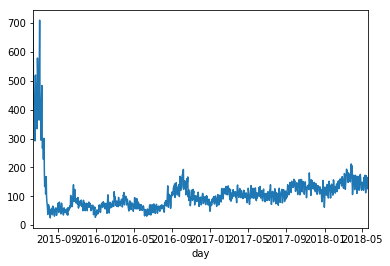

In [8]:
df.groupby('day') \
    .user_id.nunique().plot()

Надстройка от seaborn

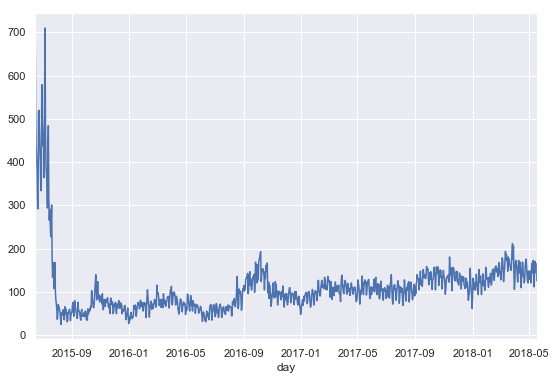

In [9]:
sns.set(rc={'figure.figsize':(9, 6)})
df.groupby('day') \
    .user_id.nunique().plot()

Количество пройденных степов

In [10]:
df.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Неверное решение

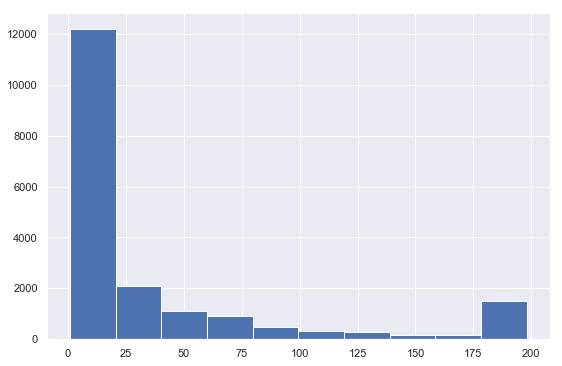

In [11]:
df[(df.action == 'discovered')] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id':'count'}) \
    .rename(columns={'step_id':'num'}).num.hist()

Pivot_table

In [82]:
user_detail = df.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0) \
    .reset_index()

In [13]:
st = pd.read_csv('submissions_data_train.csv')

In [14]:
st['date'] = pd.to_datetime(st.timestamp, unit='s')
st['day'] = st.date.dt.date

Для каждого пользователя отобразить его прав/неправ ответы

In [15]:
user_score = st.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0) \
    .reset_index()

In [16]:
user_score.head().reset_index()

submission_status,index,user_id,correct,wrong
0,0,2,2,0
1,1,3,29,23
2,2,5,2,2
3,3,8,9,21
4,4,14,0,1


Собраем статистику по времени отстутвия

Убирем лишнее/ оставляем только дни

In [17]:
df.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [20]:
df[['user_id', 'step_id', 'timestamp']].head().drop_duplicates()

,user_id,step_id,timestamp
0,17632,32815,1434340848
3,17632,32811,1434340895


In [24]:
df[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

np.diff

In [25]:
np.diff([1, 2, 4])

array([1, 2])

In [43]:
gaps_data = df[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

np.concetencate/ axis=0 -- this is rows

In [44]:
gaps = pd.Series(np.concatenate(gaps_data, axis=0))

In [45]:
gaps = gaps / (24 * 60 * 60)

In [47]:
gaps.quantile(0.95)

59.760440972222156

In [64]:
now = 1526772811
drop_t = 30 * 24 * 60 * 60

Дополнение данными

In [115]:
user_t = df.groupby('user_id', as_index=False).agg({'timestamp':'max'})

In [116]:
user_t['if_drop'] = ((now - user_t['timestamp']) > drop_t)

In [118]:
user_t = user_t.rename(columns={'timestamp':'last_d'})

In [126]:
user_t

,user_id,last_d,if_drop,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
5,8,1481466913,True,9.0,21.0,109,84,37,156,2
6,9,1484999497,True,0.0,0.0,3,3,0,4,1
7,11,1526140625,False,0.0,0.0,1,0,1,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9,1
9,16,1513162585,True,77.0,106.0,196,196,108,651,21


In [120]:
user_t = user_t.merge(user_score, on='user_id', how='outer').fillna(0)

In [121]:
user_t = user_t.merge(user_detail, on='user_id', how='outer')

In [122]:
user_nq_days = df.groupby('user_id').day.nunique().to_frame()

In [123]:
user_t = user_t.merge(user_nq_days, on='user_id', how='outer')

Проверка

In [124]:
user_t.user_id.nunique()

19234

In [125]:
df.user_id.nunique()

19234

Дополним последним пунктом

In [128]:
need_passed = 170
user_t['passed_ind'] = (user_t.passed > need_passed)

In [131]:
res = user_t.groupby('passed_ind').count()

result

In [142]:
answ = 100 * res.iloc[1, 1]/res.iloc[0, 1] 
answ

8.001572238755685

In [148]:
user_t.head()

,user_id,last_d,if_drop,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_ind
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [152]:
user_t.sort_values('viewed', ascending=False).head()

,user_id,last_d,if_drop,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_ind
15007,20907,1453480839,True,0.0,0.0,163,102,0,32778,221,False
7780,10794,1501136015,True,0.0,0.0,198,122,27,16089,281,False
18150,25279,1503065555,True,0.0,0.0,198,122,166,9693,75,False
781,1046,1525160857,False,421.0,513.0,128,124,721,8122,478,False
2611,3572,1526732794,False,113.0,398.0,194,193,550,6968,236,True
